# EDA Notebook 01 — Poverty Imputation Challenge

## Τι είναι τα δεδομένα μας
Έχουμε δεδομένα από **household surveys** (πολλαπλά έτη / panels).  
Για κάθε νοικοκυριό υπάρχουν:
- **Survey responses (features)**: δημογραφικά, εκπαίδευση/εργασία, κατοικία, γεωγραφία, food indicators κ.ά.
- **Sampling / population weights**: βάρη που αντιπροσωπεύουν πόσο “πληθυσμό” καλύπτει κάθε νοικοκυριό.
- **Label (μόνο στο train)**: ημερήσια κατανάλωση ανά άτομο (per-capita daily consumption, 2017 USD PPP).

## Τι θέλουμε να προβλέψουμε
Το challenge ζητάει 2 ειδών προβλέψεις:
1) **Household-level**: για κάθε household στο test, να προβλέψουμε `per_capita_household_consumption` (συνεχές regression).
2) **Survey-level**: για κάθε survey στο test, να προβλέψουμε το ποσοστό πληθυσμού κάτω από 19 thresholds (poverty rates), με χρήση των weights.

Το scoring δίνει πολύ μεγαλύτερη σημασία στα poverty rates (90%), άρα μας νοιάζει να “πιάσουμε” σωστά την κατανομή της κατανάλωσης.

## Γιατί ξεκινάμε με αυτά τα 2 CSV
Στο EDA ξεκινάμε από το household-level κομμάτι:
- `train_hh_features.csv`: τα **X** (features ανά household)
- `train_hh_gt.csv`: το **y** (consumption label ανά household)

Τα ενώνουμε (merge) με το household identifier (π.χ. `hhid` και συνήθως και `survey_id`) ώστε να έχουμε **ένα master dataframe**:  
**μία γραμμή = ένα household**, με όλα τα features και το target.

Στόχος του πρώτου βήματος:
- να επιβεβαιώσουμε ότι τα κλειδιά (IDs) “ταιριάζουν” σωστά,
- να δούμε βασικές στατιστικές / missingness,
- να ελέγξουμε ότι τα labels (consumption) είναι λογικά πριν κάνουμε οποιοδήποτε modeling.




pandas / numpy

matplotlib / seaborn

display.max_columns = None: γιατί τα survey datasets έχουν πολλές στήλες και δεν θέλουμε truncated view.

float_format: για να βλέπουμε consumption / weights καθαρά.

warnings off

In [1]:
# Core data handling
import pandas as pd
import numpy as np

# Visualization (θα τα χρησιμοποιήσουμε στα επόμενα cells)
import matplotlib.pyplot as plt
import seaborn as sns

# Quality-of-life settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", "{:.4f}".format)

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load household-level training features
train_features = pd.read_csv("c:/Users/user/poverty-prediction/data/raw/train_hh_features.csv")

#EDA on train_features
train_features.shape
train_features.head()
train_features.columns.tolist()
train_features["survey_id"].value_counts().sort_index()

survey_id
100000    32188
200000    34584
300000    37462
Name: count, dtype: int64

In [3]:
train_gt = pd.read_csv("c:/Users/user/poverty-prediction/data/raw/train_hh_gt.csv")
train_gt.shape
train_gt.head()
train_gt.columns.tolist()
train_gt["survey_id"].value_counts().sort_index()

survey_id
100000    32188
200000    34584
300000    37462
Name: count, dtype: int64

Ελέγχουμε αν το ζεύγος (survey_id, hhid) είναι μοναδικό στα train_features και train_gt.
Γιατί: Θέλουμε το merge να είναι 1–1 (κάθε household να παίρνει ακριβώς ένα label). Αν υπάρχουν διπλότυπα, το merge μπορεί να “φουσκώσει” γραμμές (many-to-many) και να καταστρέψει όλο το training/EDA σιωπηλά.

In [4]:


key_cols = ["survey_id", "hhid"]

# 1) Duplicates in features
dup_features = train_features.duplicated(subset=key_cols).sum()
print(f"Duplicate (survey_id, hhid) rows in train_features: {dup_features}")

# 2) Duplicates in ground truth
dup_gt = train_gt.duplicated(subset=key_cols).sum()
print(f"Duplicate (survey_id, hhid) rows in train_gt: {dup_gt}")



Duplicate (survey_id, hhid) rows in train_features: 0
Duplicate (survey_id, hhid) rows in train_gt: 0


Ενώνουμε τα household features με το household consumption label χρησιμοποιώντας (survey_id, hhid)

In [5]:
# Merge 
train_df = train_features.merge(
    train_gt,
    on=["survey_id", "hhid"],
    how="inner",
    validate="one_to_one"
)

# Sanity checks
print("train_features shape:", train_features.shape)
print("train_gt shape:", train_gt.shape)
print("train_df shape:", train_df.shape)

# Check if any rows were lost
expected_rows = train_features.shape[0]
actual_rows = train_df.shape[0]
print(f"Rows lost after merge: {expected_rows - actual_rows}")
target_col = "cons_ppp17"

print("Target missing values:", train_df[target_col].isna().sum())
train_df[[ "survey_id", "hhid", target_col ]].head()


train_features shape: (104234, 88)
train_gt shape: (104234, 3)
train_df shape: (104234, 89)
Rows lost after merge: 0
Target missing values: 0


,survey_id,hhid,cons_ppp17
0,100000,100001,25.2584
1,100000,100002,16.9967
2,100000,100003,13.6718
3,100000,100004,7.1895
4,100000,100005,12.3089


Έλεγχος στο Target value ανα survey 

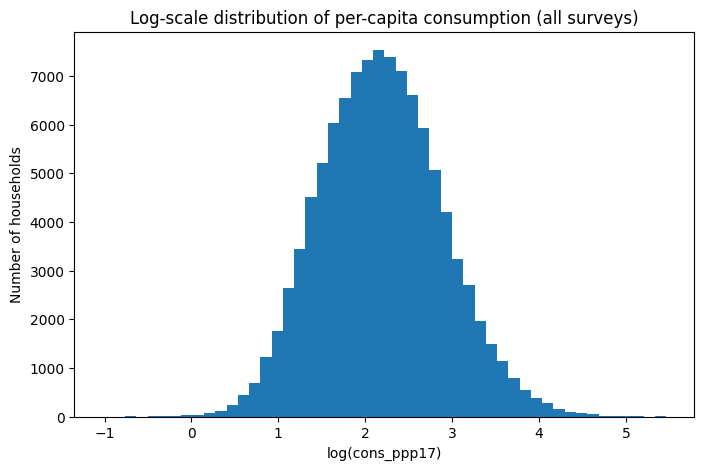

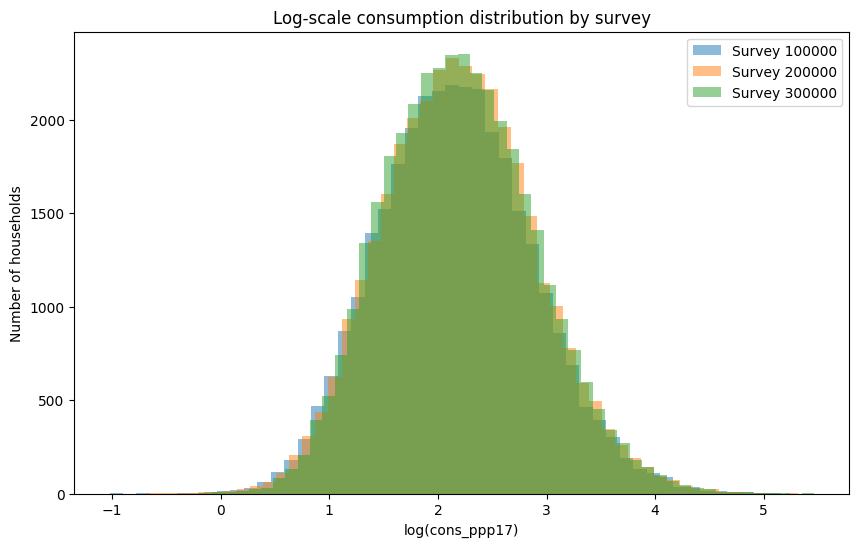

In [6]:

target_col = "cons_ppp17"

# 1) Basic statistics (global)
train_df[target_col].describe(percentiles=[0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99])
# 2) Log-scale histogram (global)
plt.figure(figsize=(8, 5))
plt.hist(np.log(train_df[target_col]), bins=50)
plt.title("Log-scale distribution of per-capita consumption (all surveys)")
plt.xlabel("log(cons_ppp17)")
plt.ylabel("Number of households")
plt.show()
# 3) Log-scale histogram per survey
plt.figure(figsize=(10, 6))

for sid in sorted(train_df["survey_id"].unique()):
    subset = train_df.loc[train_df["survey_id"] == sid, target_col]
    plt.hist(np.log(subset), bins=50, alpha=0.5, label=f"Survey {sid}")

plt.title("Log-scale consumption distribution by survey")
plt.xlabel("log(cons_ppp17)")
plt.ylabel("Number of households")
plt.legend()
plt.show()


 Global log-distribution (όλα τα surveys μαζί)
Τι βλέπουμε

Σχεδόν κανονική (Gaussian) κατανομή στο log-scale

Ένα καθαρό mode γύρω στο log(cons) ≈ 2

Smooth tails, χωρίς spikes ή multimodality

Τι σημαίνει

Το cons_ppp17 είναι log-normal distributed

Το log(cons_ppp17) είναι άριστος regression target

Δεν έχουμε:

data corruption

weird coding artifacts

broken surveys

Αυτό μόνο του ανεβάζει πολύ το ceiling του μοντέλου.

 Ανά survey (100k / 200k / 300k)
Τι βλέπουμε

Οι 3 καμπύλες:

σχεδόν πλήρως επικαλυπτόμενες

ίδιο shape

ίδιο spread

πολύ μικρό shift στο mode (αν υπάρχει)

Τι σημαίνει (ΠΟΛΥ ΣΗΜΑΝΤΙΚΟ)

Ελάχιστο domain shift

Τα surveys είναι:

καλά harmonized

συγκρίσιμα

Μπορούμε:

να κάνουμε pooled training

να χρησιμοποιήσουμε cross-survey CV

να περιμένουμε ότι το μοντέλο θα γενικεύσει στα test surveys

## Cell 8 — Sampling / Population Weights: Sanity & Distribution

Στόχος αυτού του cell είναι να καταλάβουμε **πώς συμπεριφέρονται τα weights**, γιατί:
- τα poverty rates **δεν** υπολογίζονται απλά ως ποσοστό households,
- αλλά ως **population-weighted ποσοστό**.

### Γιατί τα weights είναι κρίσιμα
- Κάθε household εκπροσωπεί **διαφορετικό αριθμό ατόμων** στον πληθυσμό.
- Τα weights επηρεάζουν άμεσα:
  - την εκτίμηση της κατανομής κατανάλωσης,
  - τα poverty thresholds (CDF),
  - και τελικά το **90% του score**.

Αν τα weights έχουν:
- ακραία outliers,
- έντονη ασυμμετρία,
- ή διαφορετική συμπεριφορά ανά survey,

τότε:
- το μοντέλο μπορεί να είναι καλό σε household MAPE,
- αλλά να αποτυγχάνει στα poverty rates.

### Τι θα ελέγξουμε
1. **Βασικά στατιστικά των weights** (min / max / percentiles).
2. **Κατανομή των weights (log-scale)** για να δούμε αν είναι heavy-tailed.
3. **Σύγκριση κατανομών weights ανά survey**, για να εντοπίσουμε πιθανό survey-level bias.



count   104234.0000
mean       926.3573
std       1121.6801
min          2.0000
1%          20.0000
5%          73.0000
10%        126.0000
50%        582.0000
90%       2040.0000
95%       3070.0000
99%       5690.0000
max      23832.0000
Name: weight, dtype: float64

Missing weights: 0
Non-positive weights (<=0): 0


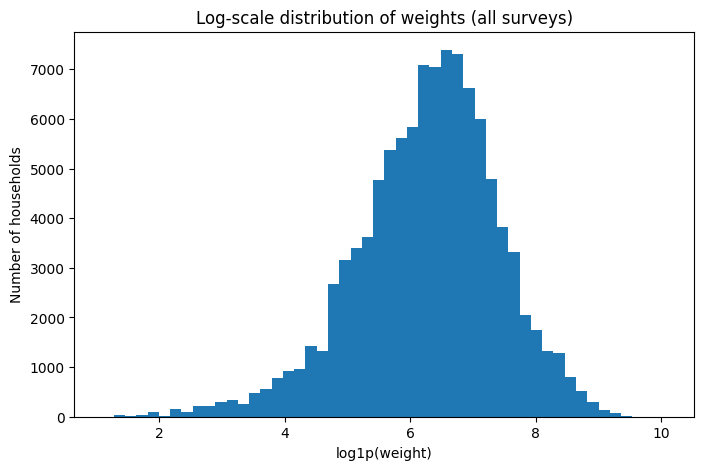

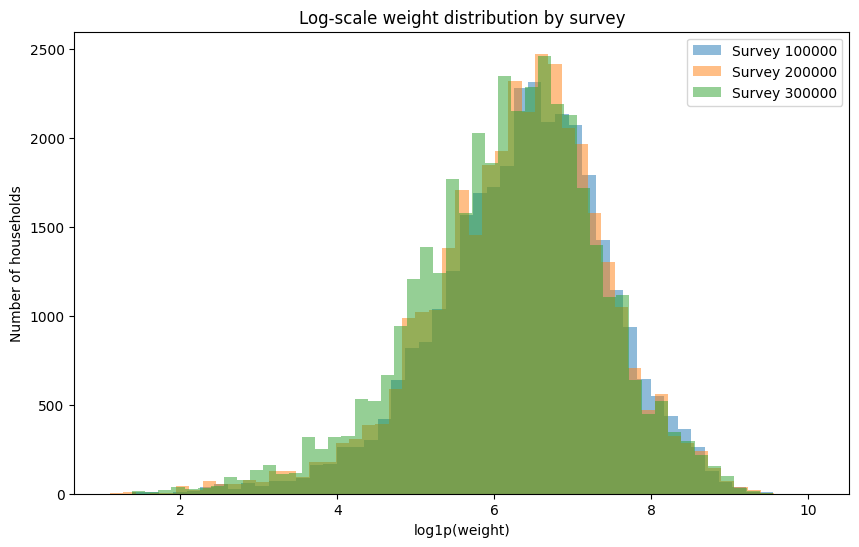

In [7]:
# --- Cell 8 (clean): Weights sanity & distribution ---

weight_col = "weight"

# Basic stats + sanity
display(train_df[weight_col].describe(percentiles=[0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]))
print("Missing weights:", train_df[weight_col].isna().sum())
print("Non-positive weights (<=0):", (train_df[weight_col] <= 0).sum())
# Log-scale histogram (all surveys)
plt.figure(figsize=(8, 5))
plt.hist(np.log1p(train_df[weight_col]), bins=50)
plt.title("Log-scale distribution of weights (all surveys)")
plt.xlabel(f"log1p({weight_col})")
plt.ylabel("Number of households")
plt.show()
# Log-scale histogram by survey
plt.figure(figsize=(10, 6))
for sid in sorted(train_df["survey_id"].unique()):
    subset = train_df.loc[train_df["survey_id"] == sid, weight_col]
    plt.hist(np.log1p(subset), bins=50, alpha=0.5, label=f"Survey {sid}")

plt.title("Log-scale weight distribution by survey")
plt.xlabel(f"log1p({weight_col})")
plt.ylabel("Number of households")
plt.legend()
plt.show()




Αργότερα:
Δεν θα βάλουμε τα weights ως feature στο regression
ΑΛΛΑ:
θα τα χρησιμοποιούμε σε:
loss weighting (πιθανόν)
CV metric
poverty computation


Επαναϋπολογίζουμε τα poverty rates από train_df (consumption + weights), ανά survey, και τα συγκρίνουμε με το train_rates_gt για να επιβεβαιώσουμε ότι καταλαβαίνουμε 100% τον ορισμό και το weighting.

In [8]:

# Load ground-truth poverty rates
rates_gt = pd.read_csv("c:/Users/user/poverty-prediction/data/raw/train_rates_gt.csv")

# Identify threshold columns (exclude survey_id)
threshold_cols = [c for c in rates_gt.columns if c != "survey_id"]

# Extract numeric thresholds from column names (e.g., pct_hh_below_3.17 -> 3.17)
thresholds = [float(c.split("_")[-1]) for c in threshold_cols]

# Sanity check
list(zip(threshold_cols[:5], thresholds[:5]))
# Function to compute weighted poverty rates for a single survey
def compute_poverty_rates(df_survey, thresholds, cons_col="cons_ppp17", w_col="weight"):
    total_weight = df_survey[w_col].sum()
    rates = []
    for t in thresholds:
        rate_t = (df_survey.loc[df_survey[cons_col] < t, w_col].sum()) / total_weight
        rates.append(rate_t)
    return np.array(rates)
# Recompute poverty rates per survey
computed_rates = []

for sid in sorted(train_df["survey_id"].unique()):
    df_s = train_df.loc[train_df["survey_id"] == sid]
    rates = compute_poverty_rates(df_s, thresholds)
    computed_rates.append([sid] + rates.tolist())

rates_recomputed = pd.DataFrame(
    computed_rates,
    columns=["survey_id"] + threshold_cols
)

rates_recomputed
# Compare recomputed rates with ground truth
comparison = rates_recomputed.merge(rates_gt, on="survey_id", suffixes=("_recomputed", "_gt"))

# Compute absolute and relative errors
abs_errors = {}
rel_errors = {}

for c in threshold_cols:
    abs_errors[c] = np.abs(comparison[f"{c}_recomputed"] - comparison[f"{c}_gt"])
    rel_errors[c] = abs_errors[c] / (comparison[f"{c}_gt"] + 1e-12)

abs_err_df = pd.DataFrame(abs_errors)
rel_err_df = pd.DataFrame(rel_errors)

print("Max absolute error across all surveys & thresholds:")
print(abs_err_df.max().max())

print("\nMax relative error across all surveys & thresholds:")
print(rel_err_df.max().max())
summary = pd.DataFrame({
    "survey_id": comparison["survey_id"],
    "mean_abs_error": abs_err_df.mean(axis=1),
    "max_abs_error": abs_err_df.max(axis=1)
})

summary


Max absolute error across all surveys & thresholds:
1.1102230246251565e-16

Max relative error across all surveys & thresholds:
1.5325841003803799e-15


,survey_id,mean_abs_error,max_abs_error
0,100000,0.0000,0.0000
1,200000,0.0000,0.0000
2,300000,0.0000,0.0000


1) Πρώτα: χαρτογράφηση missingness (όχι συμπλήρωση ακόμα)

Γιατί:

θέλουμε να δούμε ποια columns έχουν missing, πόσο, και αν το missingness διαφέρει ανά survey (domain shift).

πολλές φορές το “missing” είναι πληροφορία (π.χ. δεν έχει τουαλέτα → missing σε sanitation detail).

2) Μετά: αποφασίζουμε στρατηγική imputation ανά τύπο feature

Numerical: median (global ή ανά survey), ή model-based (αργότερα).

Categorical: “Unknown/Missing” category (συνήθως καλύτερο από mode).

Binary/flags: προσοχή — το NaN δεν σημαίνει 0 πάντα.

Να χαρτογραφήσουμε ποια features έχουν ελλείψεις, πόσο συχνά, και αν το missingness αλλάζει ανά survey. Αυτό μας προστατεύει από “τυφλό” imputation που μπορεί να αλλοιώσει την κατανομή κατανάλωσης και να ρίξει λάθος households κάτω/πάνω από poverty thresholds.

In [9]:

# 1) Missing % per column (overall)
missing_pct = (train_df.isna().mean() * 100).sort_values(ascending=False)

# Keep only columns with missingness
missing_pct_nonzero = missing_pct[missing_pct > 0]

print(f"Columns with missing values: {missing_pct_nonzero.shape[0]} / {train_df.shape[1]}")
missing_pct_nonzero.head(30)
# 2) Summary of missingness severity
# (How many columns fall into each missingness bucket)
bins = [0, 0.1, 1, 5, 10, 25, 50, 75, 100]
labels = ["(0-0.1%]", "(0.1-1%]", "(1-5%]", "(5-10%]", "(10-25%]", "(25-50%]", "(50-75%]", "(75-100%]"]

missing_bucket_counts = pd.cut(missing_pct_nonzero, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()
missing_bucket_counts
# 3) Missingness by survey for the top N missing columns
top_n = 20
top_missing_cols = missing_pct_nonzero.head(top_n).index.tolist()

missing_by_survey = (
    train_df.groupby("survey_id")[top_missing_cols]
    .apply(lambda g: g.isna().mean() * 100)
)

missing_by_survey
# This helps detect survey-specific skip patterns / domain shift.
survey_missing_range = pd.DataFrame({
    "missing_min_pct": missing_by_survey.min(axis=0),
    "missing_max_pct": missing_by_survey.max(axis=0),
})
survey_missing_range["range_pct"] = survey_missing_range["missing_max_pct"] - survey_missing_range["missing_min_pct"]

survey_missing_range.sort_values("range_pct", ascending=False).head(20)



Columns with missing values: 56 / 89


,missing_min_pct,missing_max_pct,range_pct
sector1d,13.2130,13.8359,0.6229
utl_exp_ppp17,0.0000,0.2269,0.2269
dweltyp,1.0918,1.1942,0.1024
consumed5000,0.0231,0.0934,0.0703
consumed4400,0.0087,0.0774,0.0687
consumed4900,0.0145,0.0801,0.0656
consumed4800,0.0145,0.0801,0.0656
consumed4600,0.0145,0.0801,0.0656
consumed4500,0.0145,0.0774,0.0630
consumed4200,0.0087,0.0694,0.0607


## Cell 11 — Feature typing & imputation rules

Στόχος αυτού του cell είναι **όχι να γράψουμε κώδικα**, αλλά να ορίσουμε ξεκάθαρα:
- τι είδους πληροφορία περιέχει κάθε κατηγορία feature,
- τι σημαίνει το missing για αυτή την κατηγορία,
- και ποιος είναι ο σωστός κανόνας imputation.

Αυτό λειτουργεί ως **specification** για το preprocessing pipeline που θα υλοποιηθεί αργότερα.

---

## 1. Numeric continuous features
**Παραδείγματα:**
- expenditures (π.χ. `utl_exp_ppp17`)
- quantities / monetary values
- household-level continuous indicators

**Χαρακτηριστικά:**
- συνήθως heavy-tailed
- χαμηλό missingness
- το NaN σημαίνει “δεν καταγράφηκε”

**Imputation rule:**
- **Median imputation** (robust σε outliers)
- Υπολογισμός **μόνο στο training set**
- Ίδια τιμή εφαρμόζεται στο test

**Σημείωση:**
- Δεν χρησιμοποιούμε mean (θα τραβηχτεί από outliers)

---

## 2. Numeric count / intensity features
**Παραδείγματα:**
- αριθμός γευμάτων
- πλήθος αντικειμένων
- food-consumption indicators τύπου `consumedXXXX`

**Χαρακτηριστικά:**
- το missing συχνά σημαίνει **μη κατανάλωση**
- όχι “άγνωστο”

**Imputation rule:**
- **Impute με 0**
- Δεν χρησιμοποιούμε median
- Δεν δημιουργούμε extra flag

**Κρίσιμη παρατήρηση:**
Σε αυτά τα features, το NaN έχει **σημασιολογικό νόημα** και ΔΕΝ είναι τυχαίο missing.

---

## 3. Binary / indicator features
**Παραδείγματα:**
- `employed`
- yes/no flags
- ownership indicators

**Χαρακτηριστικά:**
- τιμές {0,1} ή κωδικοποιημένες
- missing συχνά = not applicable

**Imputation rule:**
- Αν το missing = not applicable → **0**
- Αλλιώς → δημιουργούμε κατηγορία “Unknown” (αν categorical)

**Σημείωση:**
Δεν συμπληρώνουμε με mode αν δεν είμαστε σίγουροι για τη σημασία.

---

## 4. Categorical (nominal / ordinal) features
**Παραδείγματα:**
- `dweltyp`
- `sector1d`
- education level codes

**Χαρακτηριστικά:**
- διακριτές τιμές με σημασιολογία
- missing ≠ random

**Imputation rule:**
- Δημιουργούμε **ρητή κατηγορία “Missing / Unknown”**
- Δεν αντικαθιστούμε με mode

**Γιατί:**
- το missing μπορεί να σχετίζεται με φτώχεια
- το mode imputation “κρύβει” πληροφορία

---

## 5. Identifiers & meta-columns
**Παραδείγματα:**
- `survey_id`
- `hhid`
- sampling weights

**Κανόνας:**
- Δεν γίνονται imputation
- Δεν χρησιμοποιούνται ως numeric features στο μοντέλο

---

## 6. Αρχές που ΔΕΝ παραβιάζουμε
-  Καμία imputation βασισμένη στο test
-  Καμία χρήση ground-truth consumption στο preprocessing
-  Καμία “έξυπνη” imputation που αλλοιώνει την κατανομή

Στόχος:
> Να διατηρήσουμε την **πραγματική κατανομή κατανάλωσης**, ειδικά γύρω από τα poverty thresholds.


In [10]:

target_col = "cons_ppp17"
weight_col = "weight"
id_cols = ["survey_id", "hhid"]

feature_cols = [c for c in train_df.columns if c not in (id_cols + [target_col])]

# Basic dtype counts
dtype_counts = train_df[feature_cols].dtypes.value_counts()
dtype_counts
# Missingness summary by dtype
missing_pct = train_df[feature_cols].isna().mean() * 100
missing_by_dtype = (
    pd.DataFrame({"col": feature_cols, "dtype": train_df[feature_cols].dtypes.astype(str), "missing_pct": missing_pct.values})
    .groupby("dtype")["missing_pct"]
    .agg(["count", "mean", "median", "max"])
    .sort_values("max", ascending=False)
)
missing_by_dtype
# Quick scan: columns that look like "consumed*" (food indicators)
consumed_cols = [c for c in feature_cols if c.lower().startswith("consumed")]
print("Number of consumed* columns:", len(consumed_cols))
consumed_cols[:30]
# Cardinality profiling for numeric columns (helps detect coded categoricals)
num_cols = [c for c in feature_cols if train_df[c].dtype != "object"]

cardinality = pd.Series(
    {c: train_df[c].nunique(dropna=True) for c in num_cols}
).sort_values()

# Show low-cardinality numeric columns (likely coded categorical/binary/ordinal)
low_card = cardinality[cardinality <= 20]
print("Low-cardinality numeric columns (<=20 unique):", low_card.shape[0])
low_card.head(50)
# Inspect a few low-cardinality columns: value counts (top 10)
sample_low_card_cols = low_card.index[:8].tolist()

for c in sample_low_card_cols:
    print(f"\nColumn: {c}")
    display(train_df[c].value_counts(dropna=False).head(10))


Number of consumed* columns: 50
Low-cardinality numeric columns (<=20 unique): 15

Column: com


com
1    104234
Name: count, dtype: int64


Column: region5


region5
0    79639
1    24595
Name: count, dtype: int64


Column: region4


region4
0    98694
1     5540
Name: count, dtype: int64


Column: region3


region3
0    93144
1    11090
Name: count, dtype: int64


Column: region2


region2
0    87852
1    16382
Name: count, dtype: int64


Column: region1


region1
0    79975
1    24259
Name: count, dtype: int64


Column: region6


region6
0    93951
1    10283
Name: count, dtype: int64


Column: region7


region7
0    92149
1    12085
Name: count, dtype: int64

Συγκρίνουμε το cons_ppp17 μεταξύ households με NaN vs 0/positive στα **consumed** για να δούμε αν το NaN συμπεριφέρεται σαν “0 κατανάλωση

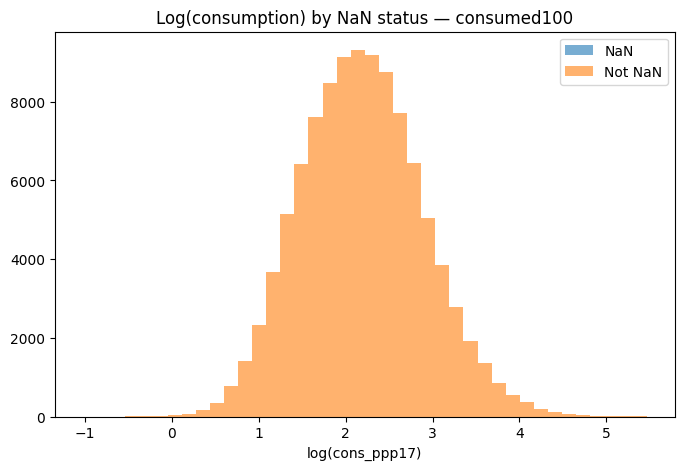

In [11]:
# --- Cell 12a: Semantic validation of consumed* features (EDA only) ---

consumed_cols = [c for c in train_df.columns if c.lower().startswith("consumed")]
target_col = "cons_ppp17"

# Pick a small, representative subset to inspect
sample_consumed_cols = consumed_cols[:6]
sample_consumed_cols
# For each sampled consumed* column:
# compare target distribution for NaN vs non-NaN
summary_rows = []

for c in sample_consumed_cols:
    df_nan = train_df[train_df[c].isna()][target_col]
    df_non_nan = train_df[train_df[c].notna()][target_col]

    summary_rows.append({
        "feature": c,
        "nan_count": df_nan.shape[0],
        "non_nan_count": df_non_nan.shape[0],
        "median_target_nan": df_nan.median(),
        "median_target_non_nan": df_non_nan.median(),
        "mean_target_nan": df_nan.mean(),
        "mean_target_non_nan": df_non_nan.mean(),
    })

consumed_nan_summary = pd.DataFrame(summary_rows)
consumed_nan_summary
# Optional: visualize one representative column
col = sample_consumed_cols[0]

plt.figure(figsize=(8, 5))
plt.hist(
    np.log(train_df.loc[train_df[col].isna(), target_col]),
    bins=40,
    alpha=0.6,
    label="NaN"
)
plt.hist(
    np.log(train_df.loc[train_df[col].notna(), target_col]),
    bins=40,
    alpha=0.6,
    label="Not NaN"
)
plt.title(f"Log(consumption) by NaN status — {col}")
plt.xlabel("log(cons_ppp17)")
plt.legend()
plt.show()


In [12]:

target_col = "cons_ppp17"
id_cols = ["survey_id", "hhid", target_col]

# 1) Dtype overview
dtype_table = (
    train_df.drop(columns=id_cols)
    .dtypes
    .value_counts()
    .rename("count")
)
dtype_table
# Detailed dtype table (per column)
dtype_per_column = (
    train_df.drop(columns=id_cols)
    .dtypes
    .astype(str)
    .to_frame("dtype")
)

dtype_per_column.head(20)
# 2) Correlation with target (numeric columns only)
numeric_cols = train_df.drop(columns=id_cols).select_dtypes(include=[np.number]).columns.tolist()

corr_with_target = (
    train_df[numeric_cols]
    .corrwith(train_df[target_col])
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

corr_with_target.head(20)
# Bottom correlations (near zero)
corr_with_target.tail(20)


sfworkershh         0.3693
region5            -0.3092
region7             0.3001
hsize              -0.2728
num_children18     -0.2213
num_children10     -0.2035
num_children5      -0.1881
sworkershh         -0.1806
region6            -0.1612
region1             0.1296
num_adult_female   -0.0781
region2             0.0641
num_adult_male     -0.0578
region3             0.0549
region4            -0.0524
age                 0.0488
weight             -0.0277
share_secondary     0.0161
num_elderly        -0.0015
com                    NaN
dtype: float64

Να δούμε ποιες στήλες είναι strings

Τι αντιπροσωπεύει η καθεμία (ελεύθερο κείμενο; κατηγορία; label;)

Cardinality (πόσες μοναδικές τιμές)

Αν είναι:

καθαρά categorical

ή metadata / noise

ή κάτι που θέλει special handling

In [13]:

target_col = "cons_ppp17"
id_cols = ["survey_id", "hhid", target_col]

object_cols = train_df.drop(columns=id_cols).select_dtypes(include=["object"]).columns.tolist()

print("Number of object (string) columns:", len(object_cols))
object_cols
# Cardinality of object columns
obj_cardinality = (
    train_df[object_cols]
    .nunique(dropna=True)
    .sort_values()
)

obj_cardinality
# Inspect top values for each object column
for c in object_cols:
    print(f"\nColumn: {c}")
    display(train_df[c].value_counts(dropna=False).head(10))


Number of object (string) columns: 64

Column: male


male
Male      75657
Female    28577
Name: count, dtype: int64


Column: owner


owner
Owner        76540
Not owner    27694
Name: count, dtype: int64


Column: water


water
Access       85296
No access    18938
Name: count, dtype: int64


Column: toilet


toilet
Access       73274
No access    30960
Name: count, dtype: int64


Column: sewer


sewer
Access       62360
No access    41874
Name: count, dtype: int64


Column: elect


elect
Access       94950
No access     9284
Name: count, dtype: int64


Column: water_source


water_source
Piped water into dwelling    81514
Surface water                 7619
Other                         4180
Piped water to yard/plot      3782
Protected dug well            2641
Public tap or standpipe       1832
Tanker-truck                  1539
Protected spring              1127
Name: count, dtype: int64


Column: sanitation_source


sanitation_source
A piped sewer system              62360
A septic tank                     10914
Pit latrine with slab             10614
No facilities or bush or field     9587
Pit latrine                        6487
Other                              4272
Name: count, dtype: int64


Column: dweltyp


dweltyp
Detached house                 93302
Separate apartment              4090
Several buildings connected     3430
Other                           2140
NaN                             1206
Improvised housing unit           66
Name: count, dtype: int64


Column: employed


employed
Employed        90105
Not employed    14084
NaN                45
Name: count, dtype: int64


Column: educ_max


educ_max
Complete Tertiary Education       29410
Complete Secondary Education      24943
Incomplete Tertiary Education     12776
Incomplete Primary Education      11297
Complete Primary Education        11130
Incomplete Secondary Education    10424
Never attended                     4231
NaN                                  23
Name: count, dtype: int64


Column: any_nonagric


any_nonagric
Yes    69239
No     34995
Name: count, dtype: int64


Column: sector1d


sector1d
Agriculture, hunting and forestry               38666
NaN                                             14129
Wholesale and retail trade                      11501
Transport, storage and communications            6577
Manufacturing                                    5557
Construction                                     5413
Public administration and defence                4139
Hotels and restaurants                           4004
Education                                        3995
Real estate, renting and business activities     2618
Name: count, dtype: int64


Column: urban


urban
Urban    63816
Rural    40418
Name: count, dtype: int64


Column: consumed100


consumed100
Yes    95063
No      9169
NaN        2
Name: count, dtype: int64


Column: consumed200


consumed200
Yes    60975
No     43257
NaN        2
Name: count, dtype: int64


Column: consumed300


consumed300
Yes    79136
No     25096
NaN        2
Name: count, dtype: int64


Column: consumed400


consumed400
Yes    78889
No     25343
NaN        2
Name: count, dtype: int64


Column: consumed500


consumed500
Yes    91161
No     13071
NaN        2
Name: count, dtype: int64


Column: consumed600


consumed600
Yes    81632
No     22601
NaN        1
Name: count, dtype: int64


Column: consumed700


consumed700
Yes    92929
No     11303
NaN        2
Name: count, dtype: int64


Column: consumed800


consumed800
Yes    60983
No     43250
NaN        1
Name: count, dtype: int64


Column: consumed900


consumed900
Yes    84764
No     19469
NaN        1
Name: count, dtype: int64


Column: consumed1000


consumed1000
No     71459
Yes    32771
NaN        4
Name: count, dtype: int64


Column: consumed1100


consumed1100
No     69397
Yes    34833
NaN        4
Name: count, dtype: int64


Column: consumed1200


consumed1200
No     92217
Yes    12012
NaN        5
Name: count, dtype: int64


Column: consumed1300


consumed1300
No     93488
Yes    10741
NaN        5
Name: count, dtype: int64


Column: consumed1400


consumed1400
No     89098
Yes    15131
NaN        5
Name: count, dtype: int64


Column: consumed1500


consumed1500
Yes    69507
No     34724
NaN        3
Name: count, dtype: int64


Column: consumed1600


consumed1600
Yes    84691
No     19539
NaN        4
Name: count, dtype: int64


Column: consumed1700


consumed1700
No     69172
Yes    35057
NaN        5
Name: count, dtype: int64


Column: consumed1800


consumed1800
No     67236
Yes    36994
NaN        4
Name: count, dtype: int64


Column: consumed1900


consumed1900
Yes    83782
No     20448
NaN        4
Name: count, dtype: int64


Column: consumed2000


consumed2000
Yes    67869
No     36362
NaN        3
Name: count, dtype: int64


Column: consumed2100


consumed2100
Yes    57805
No     46425
NaN        4
Name: count, dtype: int64


Column: consumed2200


consumed2200
No     94511
Yes     9716
NaN        7
Name: count, dtype: int64


Column: consumed2300


consumed2300
Yes    82501
No     21730
NaN        3
Name: count, dtype: int64


Column: consumed2400


consumed2400
Yes    65849
No     38384
NaN        1
Name: count, dtype: int64


Column: consumed2500


consumed2500
No     81063
Yes    23167
NaN        4
Name: count, dtype: int64


Column: consumed2600


consumed2600
No     95301
Yes     8926
NaN        7
Name: count, dtype: int64


Column: consumed2700


consumed2700
No     59423
Yes    44809
NaN        2
Name: count, dtype: int64


Column: consumed2800


consumed2800
Yes    65761
No     38468
NaN        5
Name: count, dtype: int64


Column: consumed2900


consumed2900
Yes    52873
No     51354
NaN        7
Name: count, dtype: int64


Column: consumed3000


consumed3000
Yes    88867
No     15357
NaN       10
Name: count, dtype: int64


Column: consumed3100


consumed3100
Yes    74599
No     29622
NaN       13
Name: count, dtype: int64


Column: consumed3200


consumed3200
Yes    92043
No     12176
NaN       15
Name: count, dtype: int64


Column: consumed3300


consumed3300
Yes    81341
No     22873
NaN       20
Name: count, dtype: int64


Column: consumed3400


consumed3400
Yes    80800
No     23412
NaN       22
Name: count, dtype: int64


Column: consumed3500


consumed3500
No     65260
Yes    38950
NaN       24
Name: count, dtype: int64


Column: consumed3600


consumed3600
Yes    71008
No     33203
NaN       23
Name: count, dtype: int64


Column: consumed3700


consumed3700
Yes    94030
No     10175
NaN       29
Name: count, dtype: int64


Column: consumed3800


consumed3800
Yes    83737
No     20462
NaN       35
Name: count, dtype: int64


Column: consumed3900


consumed3900
Yes    78791
No     25403
NaN       40
Name: count, dtype: int64


Column: consumed4000


consumed4000
Yes    86667
No     17529
NaN       38
Name: count, dtype: int64


Column: consumed4100


consumed4100
Yes    87636
No     16558
NaN       40
Name: count, dtype: int64


Column: consumed4200


consumed4200
Yes    88115
No     16075
NaN       44
Name: count, dtype: int64


Column: consumed4300


consumed4300
No     75542
Yes    28640
NaN       52
Name: count, dtype: int64


Column: consumed4400


consumed4400
No     91887
Yes    12295
NaN       52
Name: count, dtype: int64


Column: consumed4500


consumed4500
No     53620
Yes    50560
NaN       54
Name: count, dtype: int64


Column: consumed4600


consumed4600
No     64615
Yes    39563
NaN       56
Name: count, dtype: int64


Column: consumed4700


consumed4700
No     63936
Yes    40246
NaN       52
Name: count, dtype: int64


Column: consumed4800


consumed4800
Yes    56467
No     47711
NaN       56
Name: count, dtype: int64


Column: consumed4900


consumed4900
No     76419
Yes    27759
NaN       56
Name: count, dtype: int64


Column: consumed5000


consumed5000
No     81603
Yes    22565
NaN       66
Name: count, dtype: int64